# Binary_Classification

## 0. 개념

### 이진 분류

- 이진 분류는 데이터를 두 개의 클래스로 분류하는 문제입니다.
- 예: 스팸 메일 분류, 질병 진단, 신용 평가 등

### Sigmoid 함수

- 수식: $σ(x) = 1 / (1 + e^{-x})$

- 특징

    - S자 모양의 곡선으로, 모든 실수 입력을 0과 1 사이의 값으로 변환합니다.
    - 출력값을 확률로 해석할 수 있어 이진 분류에 적합합니다.

- 분류 기준: 출력이 0.5 이상이면 양성 클래스(1), 미만이면 음성 클래스(0)로 분류합니다.

### 손실 함수: 이진 교차 엔트로피(Binary Cross Entropy, BCE)

- 수식: $L = -Σ(y * log(p) + (1-y) * log(1-p))$

    - y: 실제 레이블 (0 또는 1)
    - p: 모델의 예측값 (0~1 사이의 확률)

- 특징

    - 예측이 실제 값과 멀어질수록 큰 패널티를 부여합니다.
    - 로그 함수의 특성으로 인해 극단적인 예측에 대해 매우 큰 손실을 발생시킵니다.

### 학습 과정

- 순전파(Forward Propagation): 입력 데이터를 모델에 통과시켜 예측값을 얻습니다.
- 손실 계산: 예측값과 실제값의 차이를 BCE로 계산합니다.
- 역전파(Backpropagation): 손실에 대한 각 파라미터의 기울기를 계산합니다.
- 최적화: 경사 하강법을 사용하여 손실 함수를 최소화하는 방향으로 모델 파라미터를 조정합니다.

## 1. 데이터 준비

먼저, 필요한 라이브러리를 import하고, 학습에 사용할 데이터를 생성하겠습니다.

In [47]:
import torch

print(torch.__version__)

2.5.0+cu121


### 1.1 선형 분리 가능한 데이터 생성

Binary_Classification를 진행하기 위해서, 2개의 클래스를 가지는 선형적으로 분리 가능한 데이터를 생성해보겠습니다.

각 클래스는 2차원 평면에서 서로 다른 영역에 위치하도록 합니다.

In [48]:
# 데이터 포인트 수
N = 64

# 클래스 1 데이터 생성
random0 = torch.randn(N//2, 1)           # 평균 0, 표준편차 1인 난수 생성
random5 = torch.randn(N//2, 1) + 5       # 평균 5, 표준편차 1인 난수 생성

class1_data_linear = torch.hstack([random0, random5])  # (x1, x2) 형태로 데이터 결합
class1_label_linear = torch.ones(N//2, 1)              # 클래스 1의 레이블을 1로 설정

# 클래스 2 데이터 생성
class2_data_linear = torch.hstack([random5, random0])
class2_label_linear = torch.zeros(N//2, 1)             # 클래스 2의 레이블을 0으로 설정

# 전체 데이터와 레이블 결합
X_linear = torch.vstack([class1_data_linear, class2_data_linear])
y_linear = torch.vstack([class1_label_linear, class2_label_linear])

print("선형 데이터의 크기:", X_linear.shape)
print("선형 레이블의 크기:", y_linear.shape)


선형 데이터의 크기: torch.Size([64, 2])
선형 레이블의 크기: torch.Size([64, 1])


### 1.2 비선형 분리 데이터 생성 (동심원 형태)

다음으로, 비선형적으로 분리되는 데이터를 생성합니다.

이 데이터는 동심원 형태를 가지며, 단순한 선형 모델로는 정확하게 분류하기 어려운 형태입니다.

In [49]:
# 데이터 포인트 수
N = 256

# 반지름 생성
radius1 = 0.3 + 0.05 * torch.randn(N//2, 1)   # 작은 원
radius2 = 1 + 0.01 * torch.randn(N//2, 1)     # 큰 원

# 각도(theta) 생성
theta = 2 * torch.pi * torch.rand(N//2, 1) - torch.pi  # -π부터 π 사이의 값

# 클래스 1 데이터 생성 (작은 원)
class1_data_nonlinear = torch.hstack([radius1 * torch.cos(theta), radius1 * torch.sin(theta)])
class1_label_nonlinear = torch.ones(N//2, 1)

# 클래스 2 데이터 생성 (큰 원)
class2_data_nonlinear = torch.hstack([radius2 * torch.cos(theta), radius2 * torch.sin(theta)])
class2_label_nonlinear = torch.zeros(N//2, 1)

# 전체 데이터와 레이블 결합
X_nonlinear = torch.vstack([class1_data_nonlinear, class2_data_nonlinear])
y_nonlinear = torch.vstack([class1_label_nonlinear, class2_label_nonlinear])

print("비선형 데이터의 크기:", X_nonlinear.shape)
print("비선형 레이블의 크기:", y_nonlinear.shape)


비선형 데이터의 크기: torch.Size([256, 2])
비선형 레이블의 크기: torch.Size([256, 1])


### 1.3 데이터 시각화

생성된 데이터를 시각화하여 분포를 확인합니다.

이를 통해 선형 데이터와 비선형 데이터의 차이를 명확히 볼 수 있습니다.

In [50]:
!sudo apt-get install fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [51]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

manager = fm.FontManager()
fm.fontManager.ttflist = manager.ttflist
plt.rc('font', family='NanumBarunGothic')

# Matplotlib 버전 확인
import matplotlib
print(matplotlib.__version__)

3.7.1


In [52]:
print(class1_data_linear)

tensor([[-0.8778,  5.4167],
        [ 0.3186,  6.1325],
        [ 0.6830,  6.2150],
        [-0.2511,  4.3385],
        [-1.1486,  3.9018],
        [ 1.3932,  5.7774],
        [-0.9846,  5.2083],
        [ 0.0549,  5.2494],
        [ 0.3917,  5.3490],
        [-1.0677,  5.1712],
        [-1.9106,  4.8052],
        [ 1.3321,  5.3808],
        [-0.6750,  4.5814],
        [ 0.8147,  5.7178],
        [-2.0233,  5.8626],
        [-1.8909,  5.4056],
        [-0.5839,  5.2507],
        [ 0.9521,  4.2318],
        [ 1.7948,  5.3641],
        [ 0.2467,  6.3892],
        [ 1.0611,  5.9961],
        [ 1.1351,  5.8552],
        [-0.2605,  4.2709],
        [-0.1085,  5.5933],
        [ 0.9937,  4.2123],
        [ 0.4174,  7.3373],
        [ 2.4539,  5.3564],
        [-0.5226,  4.5726],
        [-1.0249,  6.1471],
        [-1.4845,  3.9128],
        [ 0.4343,  4.1671],
        [ 0.7593,  6.0490]])


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from current font.



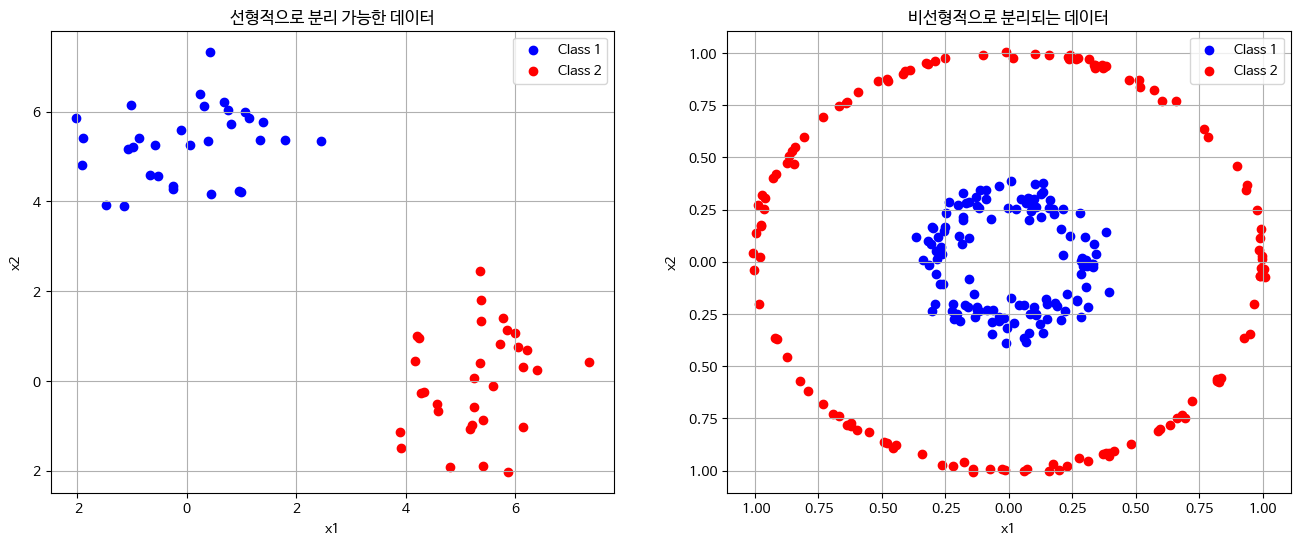

In [53]:
plt.figure(figsize=(16, 6))

# 선형 데이터 시각화
plt.subplot(1, 2, 1)
plt.scatter(class1_data_linear[:, 0], class1_data_linear[:, 1], color='blue', label='Class 1')
plt.scatter(class2_data_linear[:, 0], class2_data_linear[:, 1], color='red', label='Class 2')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("선형적으로 분리 가능한 데이터")
plt.legend()
plt.grid(True)

# 비선형 데이터 시각화
plt.subplot(1, 2, 2)
plt.scatter(class1_data_nonlinear[:, 0], class1_data_nonlinear[:, 1], color='blue', label='Class 1')
plt.scatter(class2_data_nonlinear[:, 0], class2_data_nonlinear[:, 1], color='red', label='Class 2')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("비선형적으로 분리되는 데이터")
plt.legend()
plt.grid(True)

plt.show()

## 2. 모델 정의

이제 신경망 모델을 정의하겠습니다.

처음에는 가장 간단한 모델부터 시작하여 점차 복잡한 모델로 확장해보겠습니다.

### 2.1 간단한 신경망 모델 (Plain MLP)

In [54]:
import torch.nn as nn

# 간단한 신경망 모델 정의
class PlainMLP(nn.Module):
    def __init__(self):
        super(PlainMLP, self).__init__()
        self.layer1 = nn.Linear(2, 100)   # 입력층에서 은닉층으로
        self.sigmoid = nn.Sigmoid()       # 활성화 함수
        self.layer2 = nn.Linear(100, 1)   # 은닉층에서 출력층으로

    def forward(self, x):
        x = self.layer1(x)
        x = self.sigmoid(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        return x

# 모델 인스턴스 생성
plain_model = PlainMLP()
print(plain_model)

PlainMLP(
  (layer1): Linear(in_features=2, out_features=100, bias=True)
  (sigmoid): Sigmoid()
  (layer2): Linear(in_features=100, out_features=1, bias=True)
)


### 2.2 매우 단순한 모델 (Very Simple MLP)

이번에는 은닉층이 없는 매우 단순한 모델을 만들어보겠습니다.

In [55]:
# 매우 단순한 신경망 모델 정의
class VerySimpleMLP(nn.Module):
    def __init__(self):
        super(VerySimpleMLP, self).__init__()
        self.layer = nn.Linear(2, 1)      # 입력층에서 바로 출력층으로

    def forward(self, x):
        x = self.layer(x)
        x = torch.sigmoid(x)
        return x

# 모델 인스턴스 생성
simple_model = VerySimpleMLP()
print(simple_model)

VerySimpleMLP(
  (layer): Linear(in_features=2, out_features=1, bias=True)
)


### 2.3 깊은 신경망 모델 (Deep MLP)

은닉층을 여러 개 쌓은 깊은 신경망 모델을 만들어보겠습니다.

In [56]:
# 깊은 신경망 모델 정의
class DeepMLP(nn.Module):
    def __init__(self):
        super(DeepMLP, self).__init__()
        self.layer1 = nn.Linear(2, 100)
        self.layer2 = nn.Linear(100, 100)
        self.layer3 = nn.Linear(100, 100)
        self.layer4 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.sigmoid(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        x = self.layer4(x)
        x = self.sigmoid(x)
        return x

# 모델 인스턴스 생성
deep_model = DeepMLP()
print(deep_model)

DeepMLP(
  (layer1): Linear(in_features=2, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=100, bias=True)
  (layer4): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### 2.4 매우 깊은 신경망 모델 (Very Deep MLP)

더욱 깊은 신경망 모델을 만들어보겠습니다.

In [57]:
# 매우 깊은 신경망 모델 정의
class VeryDeepMLP(nn.Module):
    def __init__(self):
        super(VeryDeepMLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2, 100))
        self.layers.append(nn.Sigmoid())
        for _ in range(10):  # 은닉층 10개 추가
            self.layers.append(nn.Linear(100, 100))
            self.layers.append(nn.Sigmoid())
        self.layers.append(nn.Linear(100, 1))
        self.layers.append(nn.Sigmoid())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# 모델 인스턴스 생성
very_deep_model = VeryDeepMLP()
print(very_deep_model)

VeryDeepMLP(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): Sigmoid()
    (10): Linear(in_features=100, out_features=100, bias=True)
    (11): Sigmoid()
    (12): Linear(in_features=100, out_features=100, bias=True)
    (13): Sigmoid()
    (14): Linear(in_features=100, out_features=100, bias=True)
    (15): Sigmoid()
    (16): Linear(in_features=100, out_features=100, bias=True)
    (17): Sigmoid()
    (18): Linear(in_features=100, out_features=100, bias=True)
    (19): Sigmoid()
    (20): Linear(in_features=100, out_features=100, bias=True)
    (21): Sigmoid()
    (22): Linear(in_features=100, out_features=1, bias=True)
 

### 2.5 활성화 함수를 ReLU로 바꾼 모델 (Very Deep MLP with ReLU)

활성화 함수를 Sigmoid 대신 ReLU로 바꾸어 모델을 만들어보겠습니다.

In [58]:
# ReLU를 사용하는 매우 깊은 신경망 모델 정의
class VeryDeepReLUMPL(nn.Module):
    def __init__(self):
        super(VeryDeepReLUMPL, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2, 100))
        self.layers.append(nn.ReLU())
        for _ in range(10):
            self.layers.append(nn.Linear(100, 100))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(100, 1))
        self.layers.append(nn.Sigmoid())  # 마지막 출력은 확률값을 위해 Sigmoid 사용

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# 모델 인스턴스 생성
very_deep_relu_model = VeryDeepReLUMPL()
print(very_deep_relu_model)

VeryDeepReLUMPL(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): Linear(in_features=100, out_features=100, bias=True)
    (11): ReLU()
    (12): Linear(in_features=100, out_features=100, bias=True)
    (13): ReLU()
    (14): Linear(in_features=100, out_features=100, bias=True)
    (15): ReLU()
    (16): Linear(in_features=100, out_features=100, bias=True)
    (17): ReLU()
    (18): Linear(in_features=100, out_features=100, bias=True)
    (19): ReLU()
    (20): Linear(in_features=100, out_features=100, bias=True)
    (21): ReLU()
    (22): Linear(in_features=100, out_features=1, bias=True)
    (23): Sigmoid()
  )
)


## 3. 모델 학습

이제 정의한 모델들을 학습시켜보겠습니다.

손실 함수로는 이진 분류에 적합한 Binary Cross Entropy를 사용하고, 최적화 알고리즘으로는 Adam을 사용합니다.

각 모델의 학습 과정을 추적하여 비교할 수 있도록 합니다.

### 3.1 학습에 필요한 라이브러리 import

In [72]:
import torch.optim as optim
import torch.nn.functional as F

### 3.2 모델 학습 함수 정의

각 모델에 대해 학습을 진행하는 함수를 정의하겠습니다.

In [73]:

simple_model = VerySimpleMLP()
deep_model = DeepMLP()

very_deep_relu_model = VeryDeepReLUMPL()

In [77]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train(model, X, y, lr, epochs):
    optimizer = optim.Adam(model.parameters(), lr=lr)  # 옵티마이저 설정
    loss_history = []  # 손실 값을 저장할 리스트

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=50, verbose=True)

    model.train()  # 모델을 학습 모드로 전환

    for epoch in range(epochs):
        y_pred = model(X)  # 순전파 -> 예측값 계산
        loss = F.binary_cross_entropy(y_pred, y)  # 손실 함수 계산

        optimizer.zero_grad()  # 기울기 초기화
        loss.backward()        # 역전파
        optimizer.step()       # 가중치 업데이트

        loss_history.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
        # 스케줄러 업데이트
        scheduler.step(loss.item())
    return loss_history


### 3.3 각 모델 학습

#### 3.3.1 간단한 모델 학습

In [78]:
print("Plain MLP 모델 학습 시작")
plain_model = PlainMLP()
plain_loss = train(plain_model, X_nonlinear, y_nonlinear, lr=0.1, epochs=100)

Plain MLP 모델 학습 시작
Epoch [10/100], Loss: 0.8002
Epoch [20/100], Loss: 0.5697
Epoch [30/100], Loss: 0.2905
Epoch [40/100], Loss: 0.1011
Epoch [50/100], Loss: 0.0361
Epoch [60/100], Loss: 0.0171
Epoch [70/100], Loss: 0.0102
Epoch [80/100], Loss: 0.0071
Epoch [90/100], Loss: 0.0055
Epoch [100/100], Loss: 0.0046


#### 3.3.2 매우 단순한 모델 학습

In [79]:
print("\nVery Simple MLP 모델 학습 시작")
simple_model = VerySimpleMLP()
simple_loss = train(simple_model, X_nonlinear, y_nonlinear, lr=0.1, epochs=100)


Very Simple MLP 모델 학습 시작
Epoch [10/100], Loss: 0.6988
Epoch [20/100], Loss: 0.6941
Epoch [30/100], Loss: 0.6938
Epoch [40/100], Loss: 0.6934
Epoch [50/100], Loss: 0.6933
Epoch [60/100], Loss: 0.6932
Epoch [70/100], Loss: 0.6932
Epoch [80/100], Loss: 0.6931
Epoch [90/100], Loss: 0.6931
Epoch [100/100], Loss: 0.6931


#### 3.3.3 깊은 신경망 모델 학습

In [80]:
print("\nDeep MLP 모델 학습 시작")
deep_model = DeepMLP()
deep_loss = train(deep_model, X_nonlinear, y_nonlinear, lr=0.1, epochs=100)


Deep MLP 모델 학습 시작
Epoch [10/100], Loss: 0.6956
Epoch [20/100], Loss: 0.6938
Epoch [30/100], Loss: 0.6957
Epoch [40/100], Loss: 0.6955
Epoch [50/100], Loss: 0.6937
Epoch [60/100], Loss: 0.6932
Epoch [70/100], Loss: 0.6933
Epoch [80/100], Loss: 0.6931
Epoch [90/100], Loss: 0.6931
Epoch [100/100], Loss: 0.6931


#### 3.3.4 매우 깊은 신경망 모델 학습
매우 깊은 모델의 경우 학습률을 낮추고 에폭 수를 늘립니다.

In [81]:
print("\nVery Deep MLP 모델 학습 시작")
very_deep_model = VeryDeepMLP()
very_deep_loss = train(very_deep_model, X_nonlinear, y_nonlinear, lr=0.1, epochs=500)


Very Deep MLP 모델 학습 시작
Epoch [10/500], Loss: 0.7006
Epoch [20/500], Loss: 0.6959
Epoch [30/500], Loss: 0.6933
Epoch [40/500], Loss: 0.6937
Epoch [50/500], Loss: 0.6931
Epoch [60/500], Loss: 0.6932
Epoch [70/500], Loss: 0.6931
Epoch [80/500], Loss: 0.6932
Epoch [90/500], Loss: 0.6932
Epoch [100/500], Loss: 0.6932
Epoch [110/500], Loss: 0.6931
Epoch [120/500], Loss: 0.6931
Epoch [130/500], Loss: 0.6931
Epoch [140/500], Loss: 0.6931
Epoch [150/500], Loss: 0.6931
Epoch [160/500], Loss: 0.6931
Epoch [170/500], Loss: 0.6931
Epoch [180/500], Loss: 0.6931
Epoch [190/500], Loss: 0.6931
Epoch [200/500], Loss: 0.6931
Epoch [210/500], Loss: 0.6931
Epoch [220/500], Loss: 0.6931
Epoch [230/500], Loss: 0.6931
Epoch [240/500], Loss: 0.6931
Epoch [250/500], Loss: 0.6931
Epoch [260/500], Loss: 0.6931
Epoch [270/500], Loss: 0.6931
Epoch [280/500], Loss: 0.6931
Epoch [290/500], Loss: 0.6931
Epoch [300/500], Loss: 0.6931
Epoch [310/500], Loss: 0.6931
Epoch [320/500], Loss: 0.6931
Epoch [330/500], Loss: 0.

#### 3.3.5 ReLU를 사용하는 매우 깊은 모델 학습

In [65]:
print("\nVery Deep ReLU MLP 모델 학습 시작")
very_deep_relu_model = VeryDeepReLUMPL()
very_deep_relu_loss = train(very_deep_relu_model, X_nonlinear, y_nonlinear, lr=0.1, epochs=500)



Very Deep ReLU MLP 모델 학습 시작
Epoch [10/500], Loss: 0.6937
Epoch [20/500], Loss: 0.6934
Epoch [30/500], Loss: 0.6932
Epoch [40/500], Loss: 0.6931
Epoch [50/500], Loss: 0.6928
Epoch [60/500], Loss: 0.6922
Epoch [70/500], Loss: 0.6906
Epoch [80/500], Loss: 0.6863
Epoch [90/500], Loss: 0.6778
Epoch [100/500], Loss: 0.6632
Epoch [110/500], Loss: 0.6428
Epoch [120/500], Loss: 0.6161
Epoch [130/500], Loss: 0.5798
Epoch [140/500], Loss: 0.5227
Epoch [150/500], Loss: 0.4164
Epoch [160/500], Loss: 0.2310
Epoch [170/500], Loss: 0.0562
Epoch [180/500], Loss: 0.0066
Epoch [190/500], Loss: 0.0012
Epoch [200/500], Loss: 0.0005
Epoch [210/500], Loss: 0.0003
Epoch [220/500], Loss: 0.0002
Epoch [230/500], Loss: 0.0002
Epoch [240/500], Loss: 0.0002
Epoch [250/500], Loss: 0.0001
Epoch [260/500], Loss: 0.0001
Epoch [270/500], Loss: 0.0001
Epoch [280/500], Loss: 0.0001
Epoch [290/500], Loss: 0.0001
Epoch [300/500], Loss: 0.0001
Epoch [310/500], Loss: 0.0001
Epoch [320/500], Loss: 0.0001
Epoch [330/500], Los

#### 3.4 학습 손실 값 시각화

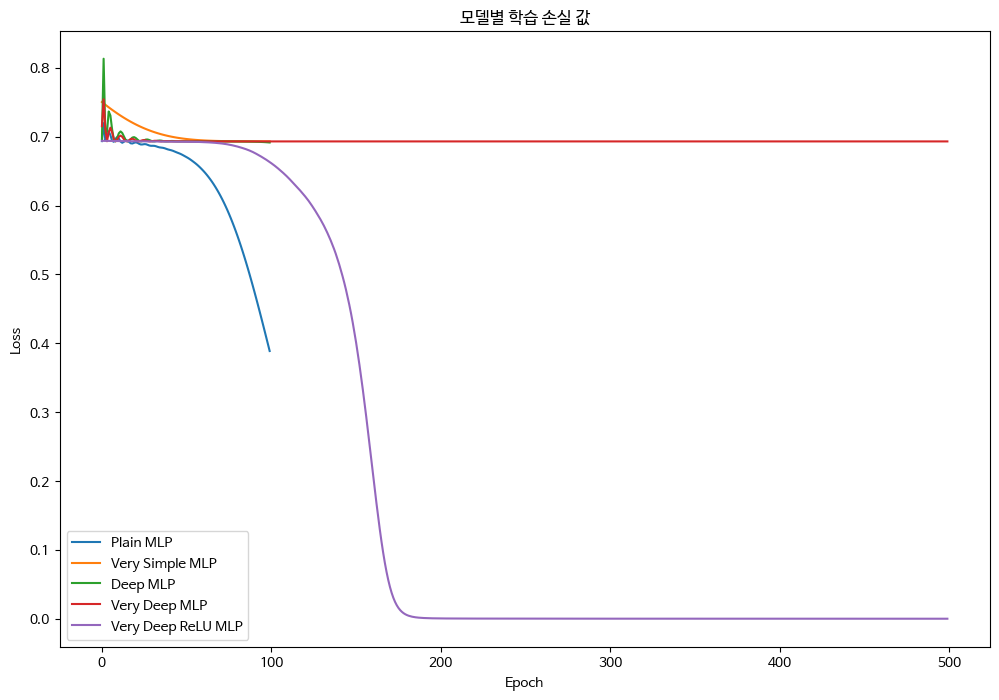

In [66]:
plt.figure(figsize=(12, 8))
plt.plot(plain_loss, label='Plain MLP')
plt.plot(simple_loss, label='Very Simple MLP')
plt.plot(deep_loss, label='Deep MLP')
plt.plot(very_deep_loss, label='Very Deep MLP')
plt.plot(very_deep_relu_loss, label='Very Deep ReLU MLP')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('모델별 학습 손실 값')
plt.legend()
plt.show()

## 4. 모델 테스트 및 결과 시각화

### 4.1 테스트 데이터 생성

모델의 예측 결과를 시각화하기 위해 테스트 데이터를 생성합니다.

In [21]:
# 테스트용 격자 데이터 생성
x1_test = torch.linspace(-2, 2, 100)
x2_test = torch.linspace(-2, 2, 100)
X1_test, X2_test = torch.meshgrid(x1_test, x2_test)
X_test = torch.stack((X1_test.flatten(), X2_test.flatten()), dim=1)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### 4.2 테스트 함수 정의

이후 시각화를 위해, 모델을 테스트하는 함수를 정의해보겠습니다.

In [22]:
# 테스트 함수 정의
def test_model(model, X_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    return y_pred.squeeze().numpy()

### 4.3 모델 예측 결과 계산

각 모델에 대해 예측 결과를 계산합니다.

In [23]:
# 모델들을 리스트에 저장
models = [plain_model, simple_model, deep_model, very_deep_model, very_deep_relu_model]
model_names = ['Plain MLP', 'Very Simple MLP', 'Deep MLP', 'Very Deep MLP', 'Very Deep ReLU MLP']
predictions = []

for model in models:
    model.eval()  # 모델을 평가 모드로 전환
    with torch.no_grad():
        y_pred = model(X_test)
        predictions.append(y_pred.reshape(X1_test.shape))


### 4.4 결과 시각화
각 모델의 예측 결과를 등고선 그래프로 시각화합니다.

<ipython-input-24-251827fe4c7b>:14: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


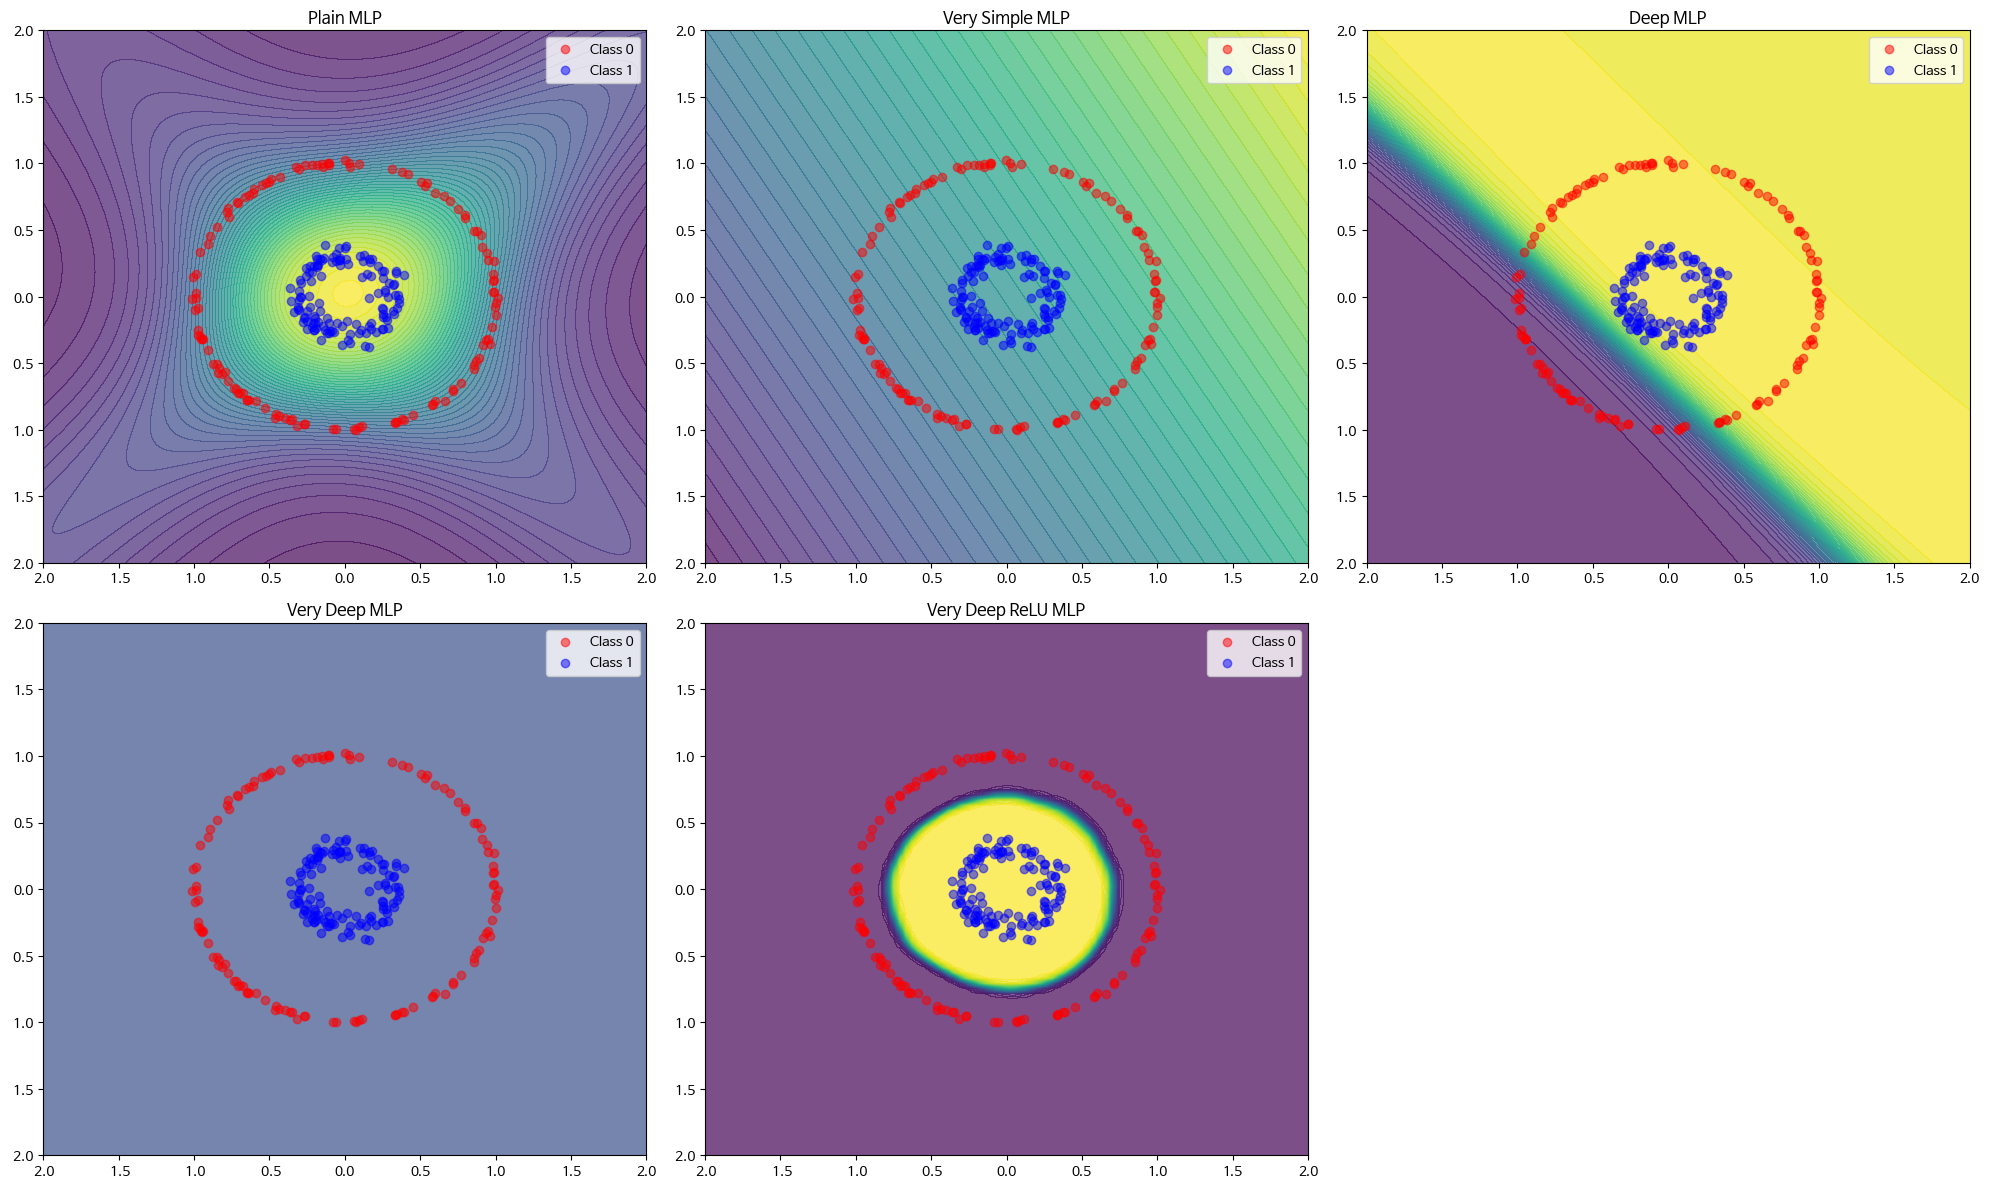

In [24]:
# 2D 시각화
plt.figure(figsize=(20, 12))
for i, model in enumerate(models):
    plt.subplot(2, 3, i+1)

    Y_pred = test_model(model, X_test).reshape(X1_test.shape)

    plt.contourf(X1_test, X2_test, Y_pred, levels=50, cmap='viridis', alpha=0.7)
    plt.scatter(X_nonlinear[y_nonlinear.squeeze() == 0, 0], X_nonlinear[y_nonlinear.squeeze() == 0, 1], color='red', label='Class 0', alpha=0.5)
    plt.scatter(X_nonlinear[y_nonlinear.squeeze() == 1, 0], X_nonlinear[y_nonlinear.squeeze() == 1, 1], color='blue', label='Class 1', alpha=0.5)
    plt.title(model_names[i])
    plt.legend()

plt.tight_layout()
plt.show()

In [25]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 3D 시각화
fig = make_subplots(rows=2, cols=3, subplot_titles=model_names, specs=[[{'type': 'surface'}]*3]*2)

for i, model in enumerate(models):
    Y_pred = test_model(model, X_test).reshape(X1_test.shape)

    row = i // 3 + 1
    col = i % 3 + 1

    fig.add_trace(
        go.Surface(x=X1_test.numpy(), y=X2_test.numpy(), z=Y_pred, colorscale="viridis", opacity=0.7),
        row=row, col=col
    )

fig.update_layout(height=1000, width=1200, title_text="Binary Classification Results for Different Models (3D)")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

## 5. 결론

이번에 우리는 PyTorch를 사용하여 다양한 구조의 신경망 모델을 통해 이진 분류 문제를 해결해보았습니다.

주요 학습 내용은 다음과 같습니다.

1. 모델의 복잡도에 따른 성능 차이: 간단한 모델부터 매우 깊은 모델까지 다양한 모델을 비교하며, 문제의 난이도에 따라 적절한 모델 선택의 중요성을 확인했습니다.

2. 활성화 함수의 영향: Sigmoid 함수와 ReLU 함수의 사용에 따른 모델 성능 변화를 관찰했습니다. ReLU를 사용한 모델이 더 빠르게 수렴하고 좋은 성능을 보일 수 있음을 알 수 있습니다.

3. 학습률과 에폭 수 조정의 중요성: 모델의 깊이에 따라 적절한 학습률과 에폭 수를 선택해야 함을 확인했습니다. 깊은 모델일수록 학습률을 낮추고 에폭 수를 늘려야 안정적인 학습이 가능합니다.

## 6. 과제

1. 왜 단순히 Layer를 깊게 쌓았을 때에는 왜 우리가 원하는 분류를 하지 못할까요? 한 번 고민해보시고, 여러분들의 의견을 공유해주세요.
2. 지금 공유 드린 것 이외에 이진 분류 성능을 개선 시킬 여지가 있다고 생각 되시는 분들은 여러분들의 아이디어를 구현해보시고, 어떤 결과가 나왔는 지 공유해주세요.